<a href="https://colab.research.google.com/github/shubham-MLwiz/Hello-World/blob/master/pretrain_1_5b_gpt_10ks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is heavily inspired from [Sebastian Raschka](https://x.com/rasbt)'s excellent book, "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)".

I highly recommend buying and reading that book.

My code here is taken directly from Sebastian's book, but with some slight variable and styling updates.

Questions?  Feel free to DM me on [Twitter](https://x.com/virattt).

In [ ]:
!pip install financial-datasets --quiet
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14

### 1. Setup the config

In [ ]:
GPT_CONFIG_1558M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,
    "n_heads": 25,
    "n_layers": 48,
    "drop_rate": 0.1,
    "qkv_bias": False
}

### 2. Implement LayerNorm

In [ ]:
import torch
from torch import nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    normalized_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * normalized_x + self.shift

### 5. Implement feed forward network with GELU activations

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
# Implement feed-forward neural network
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
        GELU(),
        nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

### 6. Implement multi-head attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out                  # 768
    self.num_heads = num_heads          # 12
    self.head_dim = d_out // num_heads  # 64
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self._out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(
            context_length,             # 1024
            context_length,             # 1024
          ), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, embedding_length = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Add the num_heads and head_dim dimensions
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)       # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim) # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)   # Transform to a tensor of dimensions: 2 x 1024 x 12 x 64

    # Transpose from (batch_size, num_tokens, num_heads, head_dim) to (batch_size, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)

    # Calculate attention scores
    attention_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    # Mask the attention scores
    attention_scores.masked_fill_(mask_bool, -torch.inf)

    # Calculate attention weights
    attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)

    # Apply dropout to attention weights
    attention_weights = self.dropout(attention_weights)

    # Calculate context vectors
    context_vectors = (attention_weights @ values).transpose(1, 2)

    # Concatenate the context vectors
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.d_out)
    return self._out_proj(context_vectors)

### 7. Implement the Transformer block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.attention = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config["context_length"],
        dropout=config["drop_rate"],
        num_heads=config["n_heads"],
        qkv_bias=config["qkv_bias"]
    )

    self.ff = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x

    # Attention layer
    x = self.norm1(x)
    x = self.attention(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back

    # Feedforward layer
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut         # Add the original input back
    return x

### 8. Implement the GPT model

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.token_embedding = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.positional_embedding = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_embedding = nn.Dropout(config["drop_rate"])

    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, sequence_length = in_idx.shape
    token_embeddings = self.token_embedding(in_idx)
    positional_embeddings = self.positional_embedding(
        torch.arange(sequence_length, device=in_idx.device)
    )
    x = token_embeddings + positional_embeddings
    x = self.drop_embedding(x)

    x = self.transformer_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_1558M)

### 9. Generate some text

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())


In [ ]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (_out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHead

In [ ]:
import tiktoken

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 11. Create data loader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

 # Create a data loader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            # The input chunk
            input_chunk = token_ids[i:i + max_length]
            # The target chunk is the input chunk, offset by 1 character
            target_chunk = token_ids[i + 1: i + max_length + 1]

            # Append chunk to list of chunks
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
# Load the data
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0
    )

    return dataloader

### 12. Download our training text

In [ ]:
from financial_datasets.parser import FilingParser

parser = FilingParser()

# AAPL 10-K
aapl_10K = parser.get_10K_items(
    ticker='AAPL',
    year=2023,
    item_names=['Item 1', 'Item 3', 'Item 7']
)

# NVDA 10-K
nvda_10K = parser.get_10K_items(
    ticker='NVDA',
    year=2023,
    item_names=['Item 1', 'Item 3', 'Item 7']
)

# MSFT 10-K
msft_10K = parser.get_10K_items(
    ticker='MSFT',
    year=2023,
    item_names=['Item 1', 'Item 3', 'Item 7']
)

In [ ]:
aapl_text = " ".join([item for item in aapl_10K])
nvda_text = " ".join([item for item in nvda_10K])
msft_text = " ".join([item for item in msft_10K])

text_data = f"{aapl_text} {nvda_text} {msft_text}"

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 258464
Total tokens: 49933


### 13. Create training / validation data

In [ ]:
train_ratio = 0.90 # 90% of data will be training, 10% will be validation
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

### 14. Implement loss functions


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  """
  Calculates the loss for a single batch.
  """
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  # Run the model
  logits = model(input_batch)

  # Calculate the loss
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0, 1),
      target_batch.flatten(),
  )
  return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  """
  Calculates the loss for all batches in a data loader.
  """
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for index, (input_batch, target_batch) in enumerate(data_loader):
    if index < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches # Return the average across all batches

In [ ]:
# Test out the loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print(f"Train loss: {train_loss}")
print(f"Val loss: {val_loss}")

Train loss: 10.985362195420539
Val loss: 10.984864807128906


### 15. Implement training functions

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  """
  Evaluates the model, giving estimate of model's training progress.
  """
  # Put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      train_loss = calc_loss_loader(
          train_loader, model, device, num_batches=eval_iter
      )
      val_loss = calc_loss_loader(
          val_loader, model, device, num_batches=eval_iter
      )
  # Put the model back in training mode
  model.train()
  return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  """
  Generates a sample text using the model.
  """
  # Put the model in evaluation mode
  model.eval()
  context_size = model.positional_embedding.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
      token_ids = generate_text_simple(
          model=model, idx=encoded,
          max_new_tokens=50, context_size=context_size
      )
      decoded_text = token_ids_to_text(token_ids, tokenizer)
      print(decoded_text.replace("\n", " "))  # Compact print format
  # Put the model back in training mode
  model.train()

In [ ]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
  """
  Trains the model.
  """
  # Initialize variables
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  # The main training loop
  for epoch in range(num_epochs):
    # Put model in training mode
    model.train()

    # Iterate through batches
    for input_batch, target_batch in train_loader:
      # Reset loss gradients from previous epoch
      optimizer.zero_grad()

      # Calculate loss for batch
      loss = calc_loss_batch(input_batch, target_batch, model, device)

      # Calculate loss gradients using backprop
      loss.backward()

      # Update model weights using loss gradients
      optimizer.step()

      # Update global variables
      tokens_seen += input_batch.numel()
      global_step += 1

      # Evaluation step (optional)
      if global_step % eval_freq == 0:
        # Evaluate the model
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        # print(f"Ep {epoch+1} (Step {global_step:06d}): "
        #       f"Train loss {train_loss:.3f}, "
        #       f"Val loss {val_loss:.3f}"
        # )

    generate_and_print_sample(
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen


### 16. Train the model

In [ ]:
import time

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,
    weight_decay=0.1,
)

num_epochs = 10

start_time = time.time()
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Fiscal year 2023 included",
    tokenizer=tokenizer,
)
end_time = time.time()
print(f"Training time: {end_time - start_time}")

Fiscal year 2023 included the Company. We. We. We. We. We the Company. We. We the Company. We. We. We. We. We. We. We. We. We. We. We. We. We. We. We
Fiscal year 2023 included. We have a variety of our products and other cloud services. Our products and other cloud services. Our Company’s products and other cloud services. We also of our products and other services. Our products and other cloud services. Our products and
Fiscal year 2023 included a wide impact of the Company’s, and other cloud services.                                   
Fiscal year 2023 included a year 2022, and the Company’s products and services. The Company’s products and services. The Company’s products and services. The Company’s products and services and the Company’s products and services.
Fiscal year 2023 included in China net sales, 2022.0.3 billion during 2023 compared to 2022. The following table year ago reflecting the year 2023, partially offset by lower net sales of the weakness in foreign currencies rel

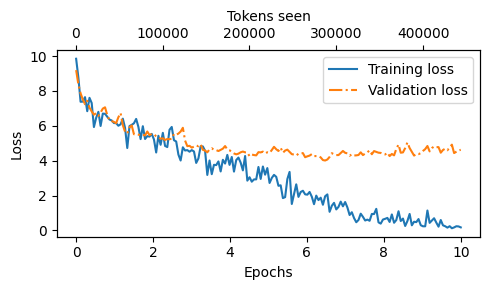

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,419,712


In [ ]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 123,822,336


### 17. Add temperature (randomness) parameter

In [ ]:
# Put model in eval mode on CPU since inference does not require compute
model.to("cpu")
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (_out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHead

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Fiscal year 2023 included", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Fiscal year 2023 included a significantly for fiscal year 2022. Fiscal year 2023 metrics are expected to be published in fiscal year 2023 reflecting the write


### 17. Save the model

In [ ]:
torch.save({
  "model_state_dict": model.state_dict(), # the model's layer -> parameter state
  "optimizer_state_dict": optimizer.state_dict(), # the AdamW optimizer's state
  },
  "model_and_optimizer.pth"
)

### 18. Load the saved model

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")

# Load the model
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

# Load the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Switch model to evaluation mode, which disables dropout
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (positional_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (_out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHead